In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from pathlib import Path
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,SubsetRandomSampler, ConcatDataset
from torchmetrics import Accuracy

from dataset import PersonalityDataset

from models.mlp import MLPsimple
from models.cnn8 import CNN8simple

In [2]:
def train_epoch(model,device,dataloader,loss_fn,optimizer,train_accuracy):
    train_loss, train_correct=0.0,0
    model.train()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        optimizer.zero_grad()
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(), labels.flatten())
        train_accuracy(output, labels.to(torch.int64))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        train_correct += (predictions == labels.to(torch.int64)).sum().item()

    return train_loss, train_correct
  
def valid_epoch(model,device,dataloader,loss_fn,val_accuracy):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for batch in dataloader:
        images, labels = batch['original'], batch['label']
        images = images.to(device)
        output = model(images)
        labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
        loss = loss_fn(output.flatten(),labels.flatten())
        val_accuracy(output, labels.to(torch.int64))
        valid_loss += loss.item() * images.size(0)
        predictions = torch.where(output>0, 1, 0)
        val_correct += (predictions == labels.to(torch.int64)).sum().item()

    return valid_loss, val_correct

| dataset | data_version | batch_norm | batch_size | dropout | lr | negative_slope | epoch |
| --- | --- | --- | --- | --- | --- | --- | --- |
| BFD | enc | True | 16 | 0.4 | 0.001 | 0.05 | 10 |
| BFD | gray | False | 16 | 0.4 | 0.001 | 0.1 | 70 |
| BFD | rgb | False | 8 | 0 | 0.00005 | 0.02 | 24 |
| --- | --- | --- | --- | --- | --- | --- | --- |
| ChaLearn | enc | False | 4 | 0.3 | 0.001 | 0.1 | 12 |
| ChaLearn | gray | True | 4 | 0 | 0.001 | 0.01 | 5 |
| ChaLearn | rgb | False | 8 | 0 | 0.00005 | 0.1 | 4 |

In [3]:
dataset_name = 'ChaLearn'
dataset_type = 'gray'

LocationConfig_data = f'data/{dataset_name}/{dataset_type}/'
params = {
    'batch_norm': True,
    'batch_size': 4,
    'dropout': 0.0,   
    'lr': 0.001,
    'negative_slope': 0.01,
}
num_epochs=5
# params = {
#     'batch_norm': False,
#     'batch_size': 16,
#     'dropout': 0.4,   
#     'lr': 0.001,
#     'negative_slope': 0.1,
# }
# num_epochs=70

In [4]:
train_dataset = PersonalityDataset(Path(LocationConfig_data + 'train/'))
test_dataset = PersonalityDataset(Path(LocationConfig_data + 'test/'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
dataset = ConcatDataset([train_dataset, test_dataset])

m=len(train_dataset)

file: data/ChaLearn/gray/train/train.pickle
file: data/ChaLearn/gray/test/test.pickle


In [6]:
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    train_accuracy = Accuracy(threshold=0.0).cuda()
    val_accuracy = Accuracy(threshold=0.0).cuda()

    print('Fold {}'.format(fold + 1))
    criterion = nn.BCEWithLogitsLoss()  
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=params['batch_size'], sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model = CNN8simple(**params)
    # model = MLPsimple(**params)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[],'train_acc_2':[],'test_acc_2':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,criterion,optimizer,train_accuracy)
        test_loss, test_correct=valid_epoch(model,device,test_loader,criterion,val_accuracy)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / (len(train_loader.sampler) * 5) * 100
        train_acc_2 = train_accuracy.compute() * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / (len(test_loader.sampler) * 5) * 100
        test_acc_2 = val_accuracy.compute() * 100

        print("F {} | E:{}/{} Tra Loss:{:.3f} Test Loss:{:.3f} Tra Acc {:.2f}% | {:.2f}% Test Acc {:.2f}% | {:.2f}%".format(
            fold + 1,
            epoch + 1,
            num_epochs,
            train_loss,
            test_loss,
            train_acc,
            train_acc_2,
            test_acc,
            test_acc_2
            ))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['train_acc_2'].append(train_acc_2.item())
        history['test_acc_2'].append(test_acc_2.item())

    foldperf['fold{}'.format(fold+1)] = history  

torch.save(model,f'model/k_cross/{dataset_name}_{dataset_type}.pt')
a_file = open(f'results/{dataset_name}_{dataset_type}.pkl', 'wb')
pickle.dump(foldperf, a_file)
a_file.close()

Fold 1


/home/karol/miniconda3/envs/ur/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
<ipython-input-2-99936aa2166b>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)
<ipython-input-2-99936aa2166b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float32, device=output.device)


F 1 | E:1/5 Tra Loss:0.644 Test Loss:0.631 Tra Acc 63.49% | 63.49% Test Acc 65.90% | 65.90%
F 1 | E:2/5 Tra Loss:0.634 Test Loss:0.622 Tra Acc 64.52% | 64.00% Test Acc 65.53% | 65.71%
F 1 | E:3/5 Tra Loss:0.631 Test Loss:0.619 Tra Acc 64.89% | 64.30% Test Acc 67.44% | 66.29%
F 1 | E:4/5 Tra Loss:0.622 Test Loss:0.609 Tra Acc 65.92% | 64.70% Test Acc 67.92% | 66.70%
F 1 | E:5/5 Tra Loss:0.617 Test Loss:0.598 Tra Acc 66.40% | 65.04% Test Acc 68.35% | 67.03%
Fold 2
F 2 | E:1/5 Tra Loss:0.641 Test Loss:0.642 Tra Acc 63.75% | 63.75% Test Acc 63.15% | 63.15%
F 2 | E:2/5 Tra Loss:0.638 Test Loss:0.629 Tra Acc 64.26% | 64.00% Test Acc 65.46% | 64.30%
F 2 | E:3/5 Tra Loss:0.636 Test Loss:0.626 Tra Acc 64.33% | 64.11% Test Acc 65.73% | 64.78%
F 2 | E:4/5 Tra Loss:0.632 Test Loss:0.621 Tra Acc 64.81% | 64.29% Test Acc 66.44% | 65.19%
F 2 | E:5/5 Tra Loss:0.627 Test Loss:0.632 Tra Acc 65.43% | 64.51% Test Acc 65.02% | 65.16%
Fold 3
F 3 | E:1/5 Tra Loss:0.643 Test Loss:0.632 Tra Acc 63.56% | 63.56%

In [25]:
testl_f,tl_f,testa_f,ta_f,testa_f2,ta_f2=[],[],[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

     ta_f2.append(np.mean(foldperf['fold{}'.format(f)]['train_acc_2']))
     testa_f2.append(np.mean(foldperf['fold{}'.format(f)]['test_acc_2']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     


Performance of 10 fold cross validation
Average Training Loss: 0.650 	 Average Test Loss: 0.629 	 Average Training Acc: 62.05 	 Average Test Acc: 66.49


In [26]:
acc_hist = {}
acc_hist['train_acc'] = ta_f
acc_hist['train_acc_2'] = ta_f2

loss_hist = {}
loss_hist['train_loss'] = tl_f
loss_hist['test_loss'] = testl_f

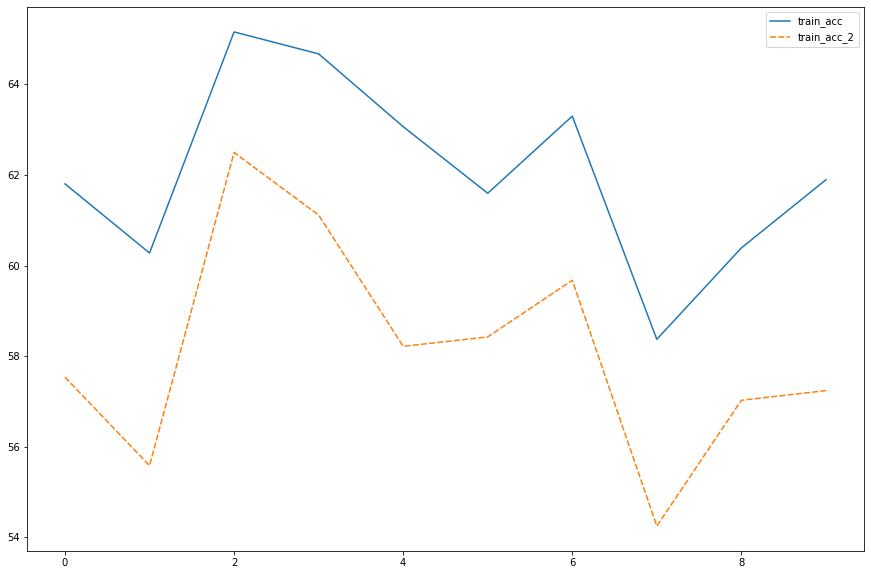

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=acc_hist)
# plt.xlabel("Typ danych", fontsize=labels_font_size)
# plt.ylabel("Dokładność zbioru walidacyjnego", fontsize=labels_font_size)
# plt.xticks(fontsize=labels_font_size) #rotation=10
# plt.yticks(fontsize=labels_font_size)
# plt.title('Dokładność zbioru walidacyjnego a typ danych', fontdict={'fontsize':20});

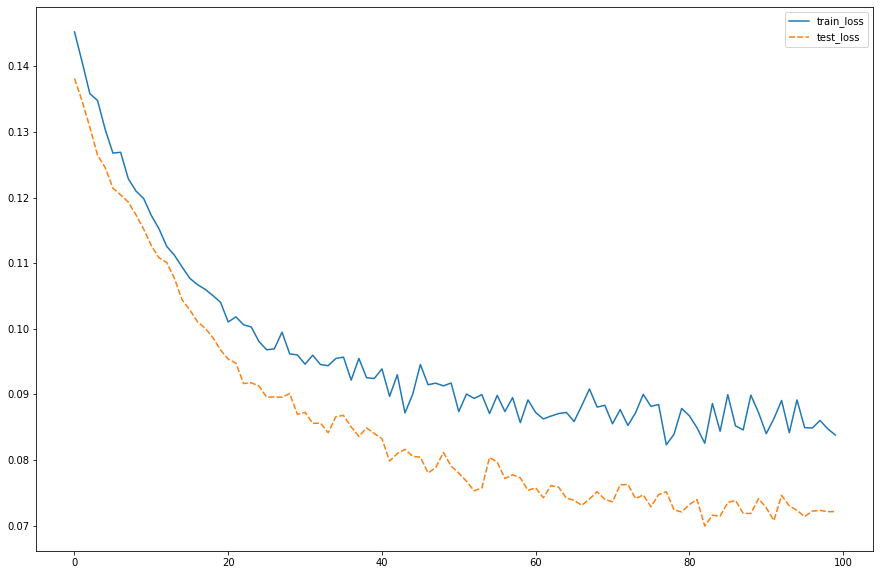

In [10]:
labels_font_size = 13
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=loss_hist)